# Part 04 – CNNs for Stereo Vision
- In this notebook, you'll dive into the world of learning-based stereo matching. Instead of relying on hand-crafted cost functions, you'll design and train a convolutional neural network (CNN) to directly predict disparity maps from stereo image pairs, following the 'Fast Architecture' from the paper [Stereo Matching by Training a Convolutional Neural Network to Compare Image Patches](https://arxiv.org/abs/1510.05970). This exercise will guide you through building a small neural network, training it on synthetic data, and evaluating its ability to estimate depth. Get ready to explore how deep learning can power 3D perception!

### Imports and static variables

In [3]:
import os
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib ipympl

PATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1) The StereoPatchTripletDataset – Your Training Data Loader (5 Points)

To train a neural network for stereo matching, we need a dataset that teaches the network to recognize which patches from two stereo images correspond to the same 3D point. This is exactly what the StereoPatchTripletDataset class provides.

In this part, you will implement this custom PyTorch dataset to load training data for your CNN.

### 👇 What this Dataset Does

This dataset returns ***triplets*** of image patches:
- **Anchor** – a patch from the left image (view1.png)
- **Positive** – a corresponding patch from the right image (view5.png) at the correct disparity (i.e. a matching patch)
- **Negative** – a randomly chosen non-matching patch from the right image, at an incorrect disparity

These triplets are ideal for training using contrastive or triplet loss, where the goal is to teach the network to bring matching patches closer in feature space and push non-matching ones apart.

### 🔍 Instructions for the implementation

Let’s break down what happens in the __getitem__ method:
1) Sample selection: A random image sample directory is selected from the dataset folder (e.g., sample_00001/) containing three files:
    - view1.png – left image
    - view5.png – right image
    - disp1.png – ground truth disparity map for the left image

2) Random pixel sampling: A valid pixel (x, y) is randomly chosen in the left image, ensuring it's not too close to the image borders.

3) Disparity lookup: The disparity value at (x, y) is read from disp1.png. This value tells us how far the corresponding pixel is shifted in the right image along the x-axis.

4) Patch extraction:
    - The anchor patch is extracted from view1 centered at (x, y).
    - The positive patch is taken from view5, shifted left by the disparity amount.
    - The negative patch is a randomly chosen patch from view5, offset by a random amount from the correct position (to simulate an incorrect match).

5) Sanity checks: If the chosen disparity is invalid or if any patch would go out of image bounds, the function retries by calling itself recursively.

6) Normalization and tensor conversion: Each patch is normalized to [0, 1] and converted to a PyTorch tensor of shape [C, H, W].

### 🧠 Why This is Useful

This dataset allows the network to learn from contrast. It sees:
- What a good match looks like (anchor vs. positive),
- What a bad match looks like (anchor vs. negative),

And it adjusts its internal parameters to produce features that make this distinction easier.

In [8]:
class StereoPatchTripletDataset(Dataset):
    def __init__(self, root_dir, patch_size=64, n_triplets=1000):
        '''
        Dataset for stereo image patch triplet generation.
        '''
        self.root_dir = root_dir
        self.patch_size = patch_size
        self.n_triplets = n_triplets
        self.samples = self._collect_samples()
        
    def set_random_generator(self, seed=42):
        '''
        Set a seed for reproducibility.
        '''
        torch.manual_seed(seed)
    
    def _collect_samples(self):
        '''
        Load the samples from the root directory.
        '''
        sample_data = []
        for sample_dir in os.listdir(self.root_dir):
            sample_path = os.path.join(self.root_dir, sample_dir)
            if os.path.isdir(sample_path):
                files = os.listdir(sample_path)
                # For training, we need all three images
                if all(f in files for f in ["view1.png", "view5.png", "disp1.png"]):
                    view1 = cv2.imread(os.path.join(sample_path, "view1.png"))
                    view5 = cv2.imread(os.path.join(sample_path, "view5.png"))
                    disp1 = cv2.imread(os.path.join(sample_path, "disp1.png"), cv2.IMREAD_UNCHANGED).astype(np.float32)
                    sample_data.append((view1, view5, disp1))
        return sample_data
    
    def __len__(self):
        '''
        Return the number of triplets in the dataset.
        '''
        return self.n_triplets

    def __getitem__(self, _):
        '''
        Generate a triplet of patches from the stereo images.
        The triplet consists of an anchor, a positive, and a negative patch.
        The anchor and positive patches are from the same view, while the negative patch is from a different view.
        The patches are randomly selected from the stereo images.
        The triplet is returned as a tuple of three tensors: (anchor, positive, negative).
        '''
        sample_idx = random.randint(0, len(self.samples) - 1)
        view1, view5, disp1 = self.samples[sample_idx]
        
        # Get image dimensions
        h, w = view1.shape[:2]
        half_patch = self.patch_size // 2
        
        # 2) Random pixel sampling: Choose a valid pixel (x, y) in the left image
        for _ in range(100):
            # Sample random coordinates with sufficient border padding
            x = random.randint(half_patch, w - half_patch - 1)
            y = random.randint(half_patch, h - half_patch - 1)
            
            # 3) Disparity lookup: Get disparity value at (x, y)
            disparity = disp1[y, x]
            
            # Skip invalid disparities (typically 0 or very large values)
            if disparity <= 0 or disparity > w // 4:
                continue
                
            # Calculate corresponding point in right image
            x_right = x - int(disparity)  # Disparity shifts left in right image
            
            # Check if positive patch would be within bounds in right image
            if x_right < half_patch or x_right >= w - half_patch:
                continue
                
            # 4) Patch extraction
            try:
                # Extract anchor patch from left image (view1)
                anchor_patch = view1[y - half_patch:y + half_patch,
                                    x - half_patch:x + half_patch]
                
                # Extract positive patch from right image (view5) at correct disparity
                positive_patch = view5[y - half_patch:y + half_patch,
                                    x_right - half_patch:x_right + half_patch]
                
                # Extract negative patch from right image at incorrect disparity
                # Add random offset to create a non-matching patch
                offset_range = max(8, int(disparity * 0.5))  # Reasonable offset based on disparity
                offset = random.randint(-offset_range, offset_range)
                while abs(offset) < 4:  # Ensure offset is significant enough
                    offset = random.randint(-offset_range, offset_range)
                    
                x_negative = x - int(disparity) + offset
                
                # Ensure negative patch is within bounds
                if x_negative < half_patch or x_negative >= w - half_patch:
                    continue
                    
                negative_patch = view5[y - half_patch:y + half_patch,
                                    x_negative - half_patch:x_negative + half_patch]
                
                # Verify all patches have correct dimensions
                if (anchor_patch.shape[:2] == (self.patch_size, self.patch_size) and
                    positive_patch.shape[:2] == (self.patch_size, self.patch_size) and
                    negative_patch.shape[:2] == (self.patch_size, self.patch_size)):
                    
                    # 5) Normalization and tensor conversion
                    # Convert BGR to RGB and normalize to [0, 1]
                    anchor_patch = cv2.cvtColor(anchor_patch, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    positive_patch = cv2.cvtColor(positive_patch, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    negative_patch = cv2.cvtColor(negative_patch, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    
                    # Convert to PyTorch tensors with shape [C, H, W]
                    anchor_tensor = torch.from_numpy(anchor_patch.transpose(2, 0, 1))
                    positive_tensor = torch.from_numpy(positive_patch.transpose(2, 0, 1))
                    negative_tensor = torch.from_numpy(negative_patch.transpose(2, 0, 1))
                    
                    return (anchor_tensor, positive_tensor, negative_tensor)
                    
            except Exception as e:
                # If patch extraction fails, continue to next attempt
                continue

## 🧩 Siamese CNN for Patch Matching

To solve the stereo matching problem using deep learning, we need a model that can tell whether two image patches (one from the left image, one from the right) correspond to the same 3D point. To do this, we’ll use a Siamese network: a neural network architecture designed to compare two inputs by embedding them into a common feature space.

### 🔧 SiameseFeatureExtractor

This class defines a small convolutional neural network (CNN) that extracts features from a single input patch. Here’s what it does:
- It takes in a patch of size [3, PATCH_SIZE, PATCH_SIZE] (a small RGB patch).
- It passes it through four convolutional layers, each followed by a ReLU activation.
- The output is a feature map of shape [64, PATCH_SIZE, PATCH_SIZE], which is then flattened into a vector of size 64 x PATCH_SIZE x PATCH_SIZE.
- Finally, this feature vector is L2-normalized to ensure its magnitude is 1 (important for cosine similarity).

This shared network will be applied to both the left and right patches — hence the term "Siamese".

### 🔁 StereoMatchingNetwork

This class defines the full stereo patch comparison network, composed of:
- A shared SiameseFeatureExtractor for both left and right patches.
- A cosine similarity function to measure how similar the two feature vectors are.

Here’s what happens during a forward pass:
- The left and right patches are independently processed by the Siamese CNN.
- The resulting feature vectors are compared using cosine similarity.
    - A value close to 1 means the patches are likely a match.
    - A value close to -1 means they are very different.

In [5]:
class SiameseFeatureExtractor(nn.Module):
    def __init__(self):
        super(SiameseFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input: [1, PATCH_SIZE, PATCH_SIZE]
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Output: [64, PATCH_SIZE, PATCH_SIZE]
        )

    def forward(self, x):
        x = self.features(x)  # Shape: [batch_size, 64, PATCH_SIZE, PATCH_SIZE]
        x = x.contiguous().view(x.size(0), -1)  # Flatten to [batch_size, 64 x PATCH_SIZE x PATCH_SIZE]
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        return x

class StereoMatchingNetwork(nn.Module):
    def __init__(self):
        super(StereoMatchingNetwork, self).__init__()
        self.feature_extractor = SiameseFeatureExtractor()

    def forward(self, patch_left, patch_right):
        # Extract features from both patches
        feat_left = self.feature_extractor(patch_left)
        feat_right = self.feature_extractor(patch_right)
        # Compute cosine similarity
        similarity = F.cosine_similarity(feat_left, feat_right, dim=1)
        return similarity

## 🏋️‍♂️ Training the Siamese Stereo Matching Network (5 Points)

Now that we have a working Siamese network architecture for comparing stereo image patches, it’s time to train it using a custom triplet-based training loop.

This part consists of implementing the training loop for our network. From dataset loading to computing the loss and optimizing the network, this part will explain you each step that needs to be implemented

### 🧮 1. Custom Hinge Loss Function

You first have to implement the hinge_loss:
$$\text{clamp}\left( \text{margin} - \text{sim\_pos} + \text{sim\_neg}, \text{min}=0 \right)$$

We use a hinge loss to train the model using triplets of patches:
- Anchor patch from the left image.
- Positive patch from the right image at the correct disparity.
- Negative patch from the right image at a wrong disparity.
The loss encourages:
- High similarity (sim_pos) for anchor–positive pairs,
- Low similarity (sim_neg) for anchor–negative pairs.


### 📦 2. Initializing the Dataset & DataLoader
We use the custom StereoPatchTripletDataset you explored earlier to sample triplets on-the-fly. The DataLoader handles:
- Batching,
- Running data loading in parallel (with num_workers).

### 🧠 3. Model and Optimizer
Create an instance of your `StereoMatchingNetwork` and move it to the GPU (if available).

Use the Adam optimizer with a small learning rate (1e-4 should work) to update the network’s weights.

### 🔁 4. Training Loop
We repeat the training over `num_epochs`. For each epoch:
- 📦 Loop Over Batches
- 📈 Forward Pass & Loss
- 🧮 Backpropagation & Optimization

---

> **Note:** Training on CPU/GPU should take only a few minutes if both the dataloader and the training loop are correctly implemented.

In [9]:

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Custom hinge loss function
def hinge_loss(sim_pos, sim_neg, margin=0.2):
    """
    Compute hinge loss for triplet training.
    Loss = clamp(margin - sim_pos + sim_neg, min=0)
    
    Args:
        sim_pos: Similarity between anchor and positive patches
        sim_neg: Similarity between anchor and negative patches
        margin: Margin for the hinge loss
    
    Returns:
        Hinge loss value
    """
    loss = torch.clamp(margin - sim_pos + sim_neg, min=0.0)
    return loss.mean()

n_triplets = 10000
batch_size = 32
num_workers = 4
lr = 1e-4

train_path = '../data/dataset/train'

# Initialize dataset and DataLoader
train_dataset = StereoPatchTripletDataset(
    root_dir=train_path,
    patch_size=PATCH_SIZE,
    n_triplets=n_triplets
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

# Initialize model and optimizer
model = StereoMatchingNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
num_epochs = 10
margin = 0.2

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Set a different random seed for each epoch for reproducibility
    train_dataset.set_random_generator(seed=42 + epoch)
    
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    pbar.set_postfix(loss=0.0)

    for batch_idx, (anchor, positive, negative) in enumerate(pbar):
        # Move data to device
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass: compute similarities
        sim_pos = model(anchor, positive)  # Similarity between anchor and positive
        sim_neg = model(anchor, negative)  # Similarity between anchor and negative
        
        # Compute the hinge loss
        loss = hinge_loss(sim_pos, sim_neg, margin=margin)
        
        # Backpropagation
        loss.backward()
        
        # Optimization step
        optimizer.step()
        
        # Update running loss and progress bar
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed!")
    

Epoch 1/10: 100%|██████████| 313/313 [00:04<00:00, 71.05batch/s, loss=0.162] 


Epoch [1/10], Loss: 0.1256


Epoch 2/10: 100%|██████████| 313/313 [00:03<00:00, 83.95batch/s, loss=0.145] 


Epoch [2/10], Loss: 0.0841


Epoch 3/10: 100%|██████████| 313/313 [00:03<00:00, 83.78batch/s, loss=0.0587]


Epoch [3/10], Loss: 0.0787


Epoch 4/10: 100%|██████████| 313/313 [00:03<00:00, 80.10batch/s, loss=0.141] 


Epoch [4/10], Loss: 0.0786


Epoch 5/10: 100%|██████████| 313/313 [00:04<00:00, 77.84batch/s, loss=0.0691]


Epoch [5/10], Loss: 0.0725


Epoch 6/10: 100%|██████████| 313/313 [00:03<00:00, 78.75batch/s, loss=0.057] 


Epoch [6/10], Loss: 0.0744


Epoch 7/10: 100%|██████████| 313/313 [00:03<00:00, 85.99batch/s, loss=0.0786] 


Epoch [7/10], Loss: 0.0714


Epoch 8/10: 100%|██████████| 313/313 [00:03<00:00, 85.81batch/s, loss=0.0763] 


Epoch [8/10], Loss: 0.0726


Epoch 9/10: 100%|██████████| 313/313 [00:04<00:00, 77.47batch/s, loss=0.0186]


Epoch [9/10], Loss: 0.0681


Epoch 10/10: 100%|██████████| 313/313 [00:03<00:00, 80.01batch/s, loss=0.12]  

Epoch [10/10], Loss: 0.0710
Training completed!


## 💾 Saving the Trained Model

After training your Siamese stereo matching network, it’s important to save the learned weights so you can later reuse the model without having to retrain it from scratch.

In [10]:
torch.save(model.state_dict(), "stereo_matching_model.pth")
print("Model saved successfully.")

Model saved successfully.


## 🔁 Loading a Saved Model for Inference or Evaluation

Once you've trained and saved your model, you’ll often want to load it back — either to make predictions, test performance, or continue training.

Here’s what each line does:

In [11]:
model = StereoMatchingNetwork()
model.load_state_dict(torch.load("stereo_matching_model.pth"))
model = model.to(device)
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


## 🎯 Let's test your results!
This script tests whether your network has actually learned something meaningful. It does so by:
- Taking two stereo images (left and right).
- Running your trained model to find, for each pixel in the left image, the most similar patch in the right image.
- The horizontal distance (disparity) between the two matching patches tells us how far the object is — that’s depth perception!

> **Note:**: this part may take a while to run on CPU as it has to call your network on many patches. If you want to test on a smaller set of pixels, consider modifying the size of the input images from [300:600, 600:900] to what may work for you. However, remember that we wil test on the whole [300:600, 600:900] interval.

### 🧠 Key Concepts
What is a disparity map?

A disparity map tells you, for every pixel in the left image, how much to shift horizontally to find the corresponding point in the right image. Larger disparity = closer object.

Computing Disparity Map: 100%|██████████| 80656/80656 [07:47<00:00, 172.65pixel/s]


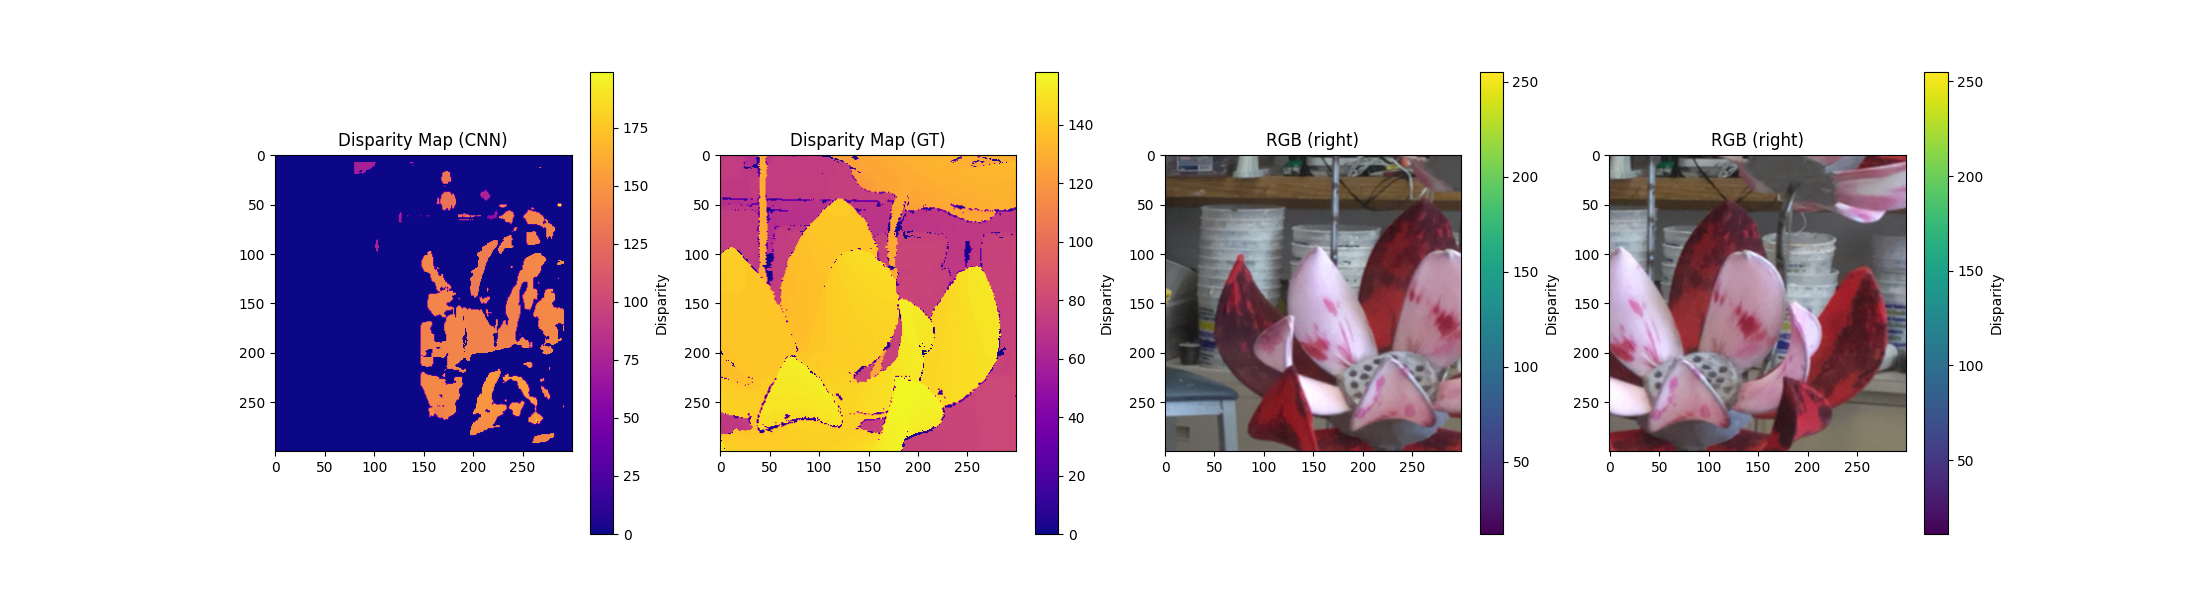

In [12]:
half_size = PATCH_SIZE // 2
max_disp = 200

def compute_disparity_map(left_img, right_img, patch_size, max_disp, cost_fn=None, device=None):

    left_img = left_img
    right_img = right_img

    h, w, _ = left_img.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)

    # Convert images to tensors
    left_img_tensor = torch.tensor(left_img).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    right_img_tensor = torch.tensor(right_img).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0

    pbar = tqdm(total=(h - PATCH_SIZE) * (w - PATCH_SIZE), desc="Computing Disparity Map", unit="pixel")

    for y in range(half_size, h - half_size):
        for x in range(half_size, w - half_size):
            # Extract patches
            left_patch = left_img_tensor[0, :, max(0, y - half_size):min(h, y + half_size), max(0, x - half_size):min(w, x + half_size)]

            right_inputs = []
            for d in range(max_disp):
                patch_x = x - d
                if patch_x < half_size:
                    patch_x = half_size

                right_inputs.append(right_img_tensor[0, :, max(0, y - half_size):min(h, y + half_size), max(0, patch_x - half_size):min(w, patch_x + half_size)])
            right_inputs = torch.stack(right_inputs).to(device)
            left_patch = left_patch.unsqueeze(0).to(device).repeat(right_inputs.shape[0], 1, 1, 1)
            # Compute costs
            with torch.no_grad():
                costs = cost_fn(left_patch, right_inputs).cpu().numpy()
                
                max_cost_idx = np.argmax(costs)
                max_cost = costs[max_cost_idx]

                disp = max_cost_idx

                if max_cost < 0.9: # threshold for valid disparity
                    disp = 0

            # Update disparity map
            disparity_map[y, x] = disp

            
            pbar.update(1)
    pbar.close()

    return disparity_map
    


left_img = cv2.imread('../data/dataset/train/artroom2/view1.png', cv2.IMREAD_COLOR_RGB)[300:600, 600:900]
right_img = cv2.imread('../data/dataset/train/artroom2/view5.png', cv2.IMREAD_COLOR_RGB)[300:600, 600:900]
gt = cv2.imread('../data/dataset/train/artroom2/disp5.png', cv2.IMREAD_COLOR_RGB)[300:600, 600:900]

# Compute and visualize disparity map (this may take a while)
disparity_cnn = compute_disparity_map(left_img, right_img, patch_size=PATCH_SIZE, max_disp=max_disp, cost_fn=model, device=device)

plt.figure(figsize=(22, 6))
plt.subplot(1, 4, 1)
plt.title('Disparity Map (CNN)')
plt.imshow(disparity_cnn, cmap='plasma')
plt.colorbar(label='Disparity')
plt.subplot(1, 4, 2)
plt.title('Disparity Map (GT)')
plt.imshow(gt[:, :, 0], cmap='plasma')
plt.colorbar(label='Disparity')
plt.subplot(1, 4, 3)
plt.title('RGB (right)')
plt.imshow(left_img)
plt.colorbar(label='Disparity')
plt.subplot(1, 4, 4)
plt.title('RGB (right)')
plt.imshow(right_img)
plt.colorbar(label='Disparity')
plt.show()

**Expected Result** (may change bit, from train to train):
![Resulting image](../data/disp_map_expected.png)

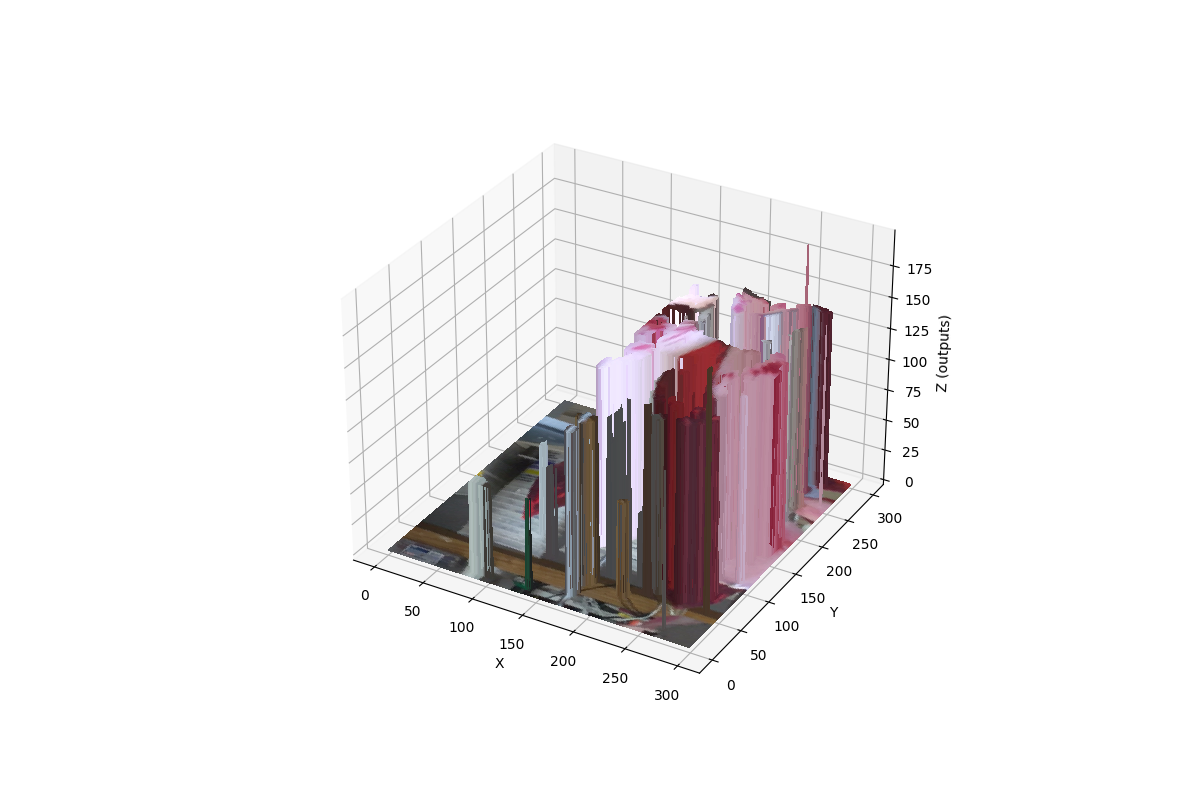

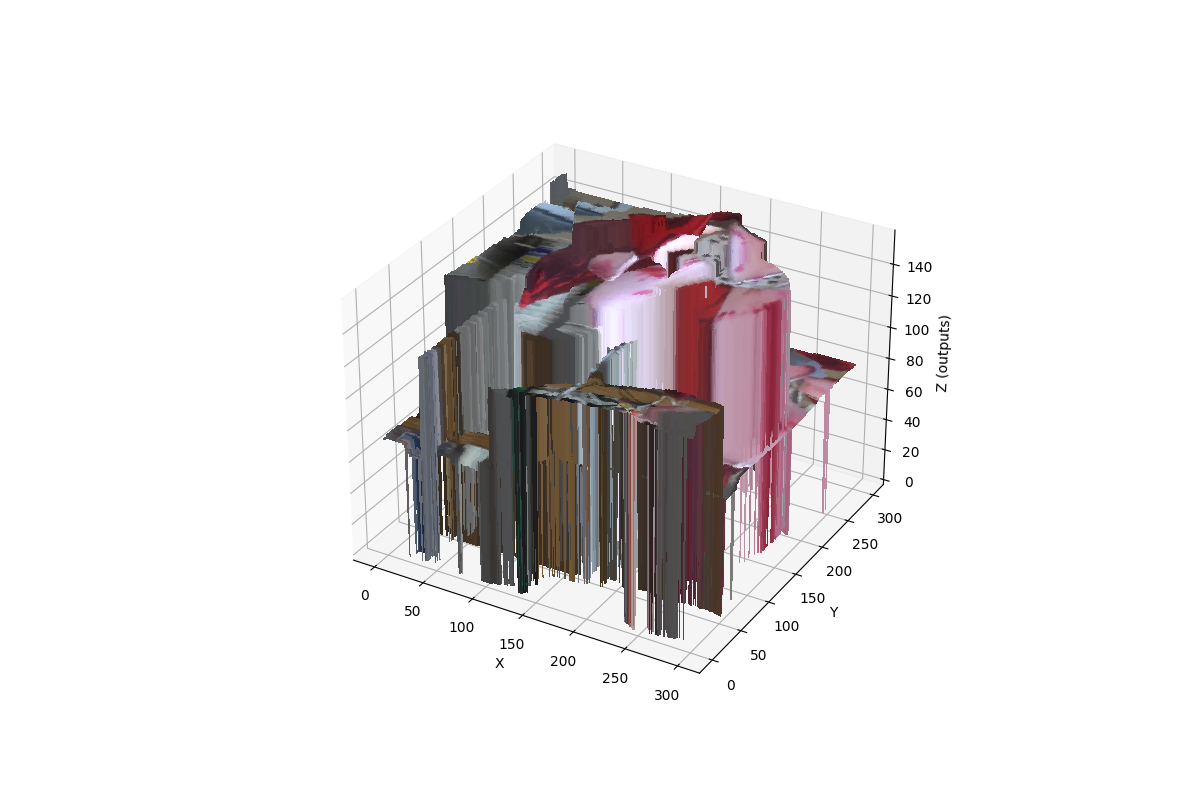

In [13]:
def plot_3d_image_with_outputs(left_img, outputs):
    h, w, _ = left_img.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    z = outputs

    # Normalize the image for color mapping
    img_normalized = left_img / 255.0

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=img_normalized, linewidth=0, antialiased=False, shade=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (outputs)')
    plt.show()

plot_3d_image_with_outputs(left_img, disparity_cnn)
plot_3d_image_with_outputs(left_img, gt[:, :, 0])

## Bonus Points: Better Models (3 Points)

As you may have noticed, the results are not 100% appealing. This is because the network did not learn enough. To get the bonus points try to improve the training.

Write here what you did for the bonus points:
...